# Predicting Electricity consumption

## Team
Dmitri Rozgonjuk <br>
Eerik Sven Puudist <br>
Triin Pohla  <br>
Andri Hõbemägi <br>

**Product Owner:** Kristjan Eljand

# Introduction
The present project was a capstone project for the Machine Learning (MTAT.03.227) course. The general aim was to predict a household's energy consumption.

## Our Approach

<font color = 'red'> DESCRIBE OUR MAIN APPROACH </font>

## Files with Detailed Workflow
<font color = 'red'> välja tuua failinimed, kus on erinevad analüüsikatsed </font>

## 0. Setup
Importing the necessary libraries and setting other settings.

In [1]:
# Dataframes and vector ops
import numpy as np
import pandas as pd
import math

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ML modules
## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
## Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet # Prophet time-series forecasting
from skforecast.ForecasterAutoreg import ForecasterAutoreg
## Metrics
from sklearn.metrics import mean_absolute_error

# MISC
import json # used for 'holidays' extraction
import requests # used for 'holidays' extraction
from copy import deepcopy
import time

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


## 1. Data Import and a Quick Glimpse
The original data set is from aggle, and the below code could be uncommented in order to download that data, unzip the file, and import the data tables that invlude training, test, and submissions data file. The submissions data file is a sample submission for testing that the data are submitted to Kaggle in the appropriate format.

In [2]:
# Download data from kaggle
#!kaggle competitions download -c predict-electricity-consumption

# Unzip the data
#!unzip predict-electricity-consumption.zip

In [3]:
# Import the data
df_train = pd.read_csv("data/train.csv")
# Rename 'consumption' to 'y_original'
df_train = df_train.rename(columns = {'consumption': 'y_original'})

df_test = pd.read_csv("data/test.csv")
df_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
print(f'Dimensions of training data: {df_train.shape}')
print(f'Earliest timepoint (training data): {min(df_train["time"])}')
print(f'Latest timepoint (training data): {max(df_train["time"])}')
df_train.head()

Dimensions of training data: (8592, 13)
Earliest timepoint (training data): 2021-09-01 00:00:00+03:00
Latest timepoint (training data): 2022-08-24 23:00:00+03:00


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,y_original
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


In [5]:
print(f'Dimensions of test data: {df_test.shape}')
print(f'Earliest timepoint (test data): {min(df_test["time"])}')
print(f'Latest timepoint (test data): {max(df_test["time"])}')
df_test.head()

Dimensions of test data: (168, 12)
Earliest timepoint (test data): 2022-08-25 00:00:00+03:00
Latest timepoint (test data): 2022-08-31 23:00:00+03:00


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price
0,2022-08-25 00:00:00+03:00,21.1,15.2,69.0,0.0,NaN,340.0,9.0,9.3,1022.0,2.0,0.25533
1,2022-08-25 01:00:00+03:00,20.1,15.1,73.0,0.0,NaN,30.0,6.0,14.8,1022.0,2.0,0.19492
2,2022-08-25 02:00:00+03:00,20.1,15.1,73.0,0.0,NaN,320.0,7.0,13.0,1022.0,2.0,0.18853
3,2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,NaN,0.0,4.0,11.1,1022.4,4.0,0.19947
4,2022-08-25 04:00:00+03:00,18.1,17.1,94.0,0.0,NaN,280.0,7.0,11.1,1022.0,3.0,0.21192


## 2. Data Preprocessing
In this section, we are extracting information from available data. Additionally, here is where we implement data transformations and prepare the final datasets for use in models.

### 2.1. Extracting Features from `time` Column
Before we start extracting information from the `time` variable, we first need to convert the column to a `datetime64` type in pandas. Then, we should look into the time range of each data set. The goal is to see what were the date ranges (for extracting additional features, e.g., holidays), and to see if the test data immediately follows training data in time sequence.

In [6]:
# Transform the 'time' column to a `datetime` format 
df_train['time'] = pd.to_datetime(df_train['time'], utc=True).map(lambda x: x.tz_convert('Europe/Helsinki'))
df_test['time'] = pd.to_datetime(df_test['time'], utc=True).map(lambda x: x.tz_convert('Europe/Helsinki'))
df_submission['time'] = pd.to_datetime(df_submission['time'], utc=True).map(lambda x: x.tz_convert('Europe/Helsinki'))

In [7]:
print(f"The range of training data: {df_train['time'].min(), df_train['time'].max()}")
print()
print(f"The range of test data: {df_test['time'].min(), df_test['time'].max()}")

The range of training data: (Timestamp('2021-09-01 00:00:00+0300', tz='Europe/Helsinki'), Timestamp('2022-08-24 23:00:00+0300', tz='Europe/Helsinki'))

The range of test data: (Timestamp('2022-08-25 00:00:00+0300', tz='Europe/Helsinki'), Timestamp('2022-08-31 23:00:00+0300', tz='Europe/Helsinki'))


Ok, from this we see that, indeed, the training and test data are sequential. The training dates range from 09.01.2021 to 24.08.2022, while the range for test data is 25.08.2022 until 31.08.2022. Now, we will also download the Estonian holidays table and keep only the rows for the relevant time period. (Let's also save the holidays table in case we need to use this in the future.)

In [8]:
# NOTE! Also possible to fetch the holidays info via 'holidays' Python module

# Fetch the list of holidays from 'riigipühad.ee'
r = requests.get('https://riigipühad.ee/?output=json')
json_str = json.dumps(r.json())
holidays = pd.read_json(json_str)
holidays['time'] = pd.to_datetime(holidays['date'], utc=True)
holidays['date'] = holidays['time'].dt.date

# Replace the values for holiday kind (to cat, and more readablity)
## 1 = 'Riigipüha' = '1_sthol' # state holiday
## 2 = 'Rahvuspüha' = '2_nathol' # national holiday
## 3 = 'Riiklik tähtpäev' = '3_natday' # nationally celebrated day
## 4 = 'Lühendatud tööpäev' = '4_shortday' # shortened day before holiday
holidays['kind_id'] = holidays['kind_id'].astype(str)
holidays['kind_id'] = holidays['kind_id'].str.replace('1', '1_sthol')
holidays['kind_id'] = holidays['kind_id'].str.replace('2', '2_nathol')
holidays['kind_id'] = holidays['kind_id'].str.replace('3', '3_natday')
holidays['kind_id'] = holidays['kind_id'].str.replace('4', '4_shortday')

In [9]:
holidays.rename(columns= {'kind_id':'h_type'}, inplace = True) # rename the col for later clarity
# holidays.to_csv('estonian_holidays.csv', index=False)

# Keep only the relevant rows
holidays = holidays[(holidays['date'] >= df_train['time'].dt.date.min()) & 
                    (holidays['date'] <= df_test['time'].dt.date.max())].reset_index(drop = True)
holidays.head()
# holidays['kind_id'].value_counts() # count the unique holiday types

# Create the mini df for merge
df_holidays = holidays.loc[:, ['date', 'h_type']]
df_holidays['is_holiday'] = np.full(len(df_holidays), 1) # 1 = is a holiday
df_holidays.head()

# might be useful for calendar data: https://towardsdatascience.com/holiday-calendars-with-pandas-9c01f1ee5fee

,date,h_type,is_holiday
0,2021-09-12,3_natday,1
1,2021-09-22,3_natday,1
2,2021-10-16,3_natday,1
3,2021-11-02,3_natday,1
4,2021-11-14,3_natday,1


Below, we are creating a helper function that extract date-related information

In [10]:
### 2.1. Create meaningful variables from 'time'
def wrangle_dates(df_original):
    """A function that turns a pd.Series datetime column to several more granular columns
    Args:
        df (pandas DataFrame): input data (e.g., df_train or df_test)
    """
    df = deepcopy(df_original)
    
    # Date variables
    df['date'] = df['time'].dt.date # date
    df['year'] = df['time'].dt.year # year
    df['month'] = df['time'].dt.month # month
    df['month_name'] = df['time'].dt.month_name() # month
    df['dow'] = df['time'].dt.dayofweek # day-of-week
    df['dayname'] = df['time'].dt.day_name() # dayname
    df['weekend'] = 0 # not weekend

    # update weekend column values if it's a weekend day
    for i in range(len(df)):
        if df['dow'][i] in [5,6]:
            df['weekend'][i] = 1 # is weekend
            
    # Time variables
    ## Only the 'hour' varies, hence no need for 'time' and 'minute'
    df['hour'] = df['time'].dt.hour.astype(int) # hour
    
    # Season
    conditions = [
        (df['month'].isin(np.arange(3,6))), (df['month'].isin(np.arange(6,9))), 
        (df['month'].isin(np.arange(9,12))), (df['month'].isin(np.arange(1,3))), (df['month'] == 12)]
    choices = ['Spring','Summer', 'Autumn', 'Winter', 'Winter']
    df['season'] = np.select(conditions, choices)
    
    # Drop numeric day-of-week, month variables
    df = df.drop(columns = ['dow', 'month'], axis = 1)
    
    # Can optionally drop the `time` variable here
    #df = df.drop(columns = ['time'], axis = 1)
    return df

In [11]:
df_train = wrangle_dates(df_train)

# Add holidays info
df_train = df_train.merge(df_holidays, on = 'date', how = 'left')
df_train['h_type'] = df_train['h_type'].fillna('not_hol').astype(str)
df_train['is_holiday'] = df_train['is_holiday'].fillna(0).astype(int)

# Custom fill for `snow` (fill with the next non-NaN value)
snow = df_train['snow'].to_numpy()
snow_index = df_train.index[~df_train['snow'].isna()].tolist()
current_snow_value = 0
for i in range(len(snow)):
    if i > 5241:
        current_snow_value = 0
        snow[i] = current_snow_value
    if i not in (snow_index):
        snow[i] = current_snow_value
    if i in (snow_index):
        current_snow_value = snow[i]
        snow[i] = current_snow_value
df_train['snow'] = snow

# Fill `prcp` with 0
df_train['prcp'] = df_train['prcp'].fillna(0.0)

# Fill NAs with last valid values, convert `coco` to categorical
df_train['coco'].fillna(method = 'ffill', inplace = True)
df_train['coco'] = df_train['coco'].astype(str)

# Remove 'date', as it's redundant
df_train = df_train.drop(columns = ['date'])

df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,el_price,y_original,year,month_name,dayname,weekend,hour,season,h_type,is_holiday
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,0.09016,0.577,2021,September,Wednesday,0,0,Autumn,not_hol,0
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,0.09251,0.594,2021,September,Wednesday,0,1,Autumn,not_hol,0
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,0.08890,0.685,2021,September,Wednesday,0,2,Autumn,not_hol,0
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,0.08735,1.016,2021,September,Wednesday,0,3,Autumn,not_hol,0
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,0.08688,0.677,2021,September,Wednesday,0,4,Autumn,not_hol,0


In [12]:
df_test = wrangle_dates(df_test)

# Add holidays info
df_test = df_test.merge(df_holidays, on = 'date', how = 'left')
df_test['h_type'] = df_test['h_type'].fillna('not_hol').astype(str)
df_test['is_holiday'] = df_test['is_holiday'].fillna(0).astype(int)

# Fill `snow` with 0 (no snow in August)
df_test['snow'] = df_test['snow'].fillna(0.0)

# Fill `prcp` with 0
df_test['prcp'] = df_test['prcp'].fillna(0.0)
df_test.head()

# Fill NAs with last valid values, convert `coco` to categorical
df_test['coco'].fillna(method = 'ffill', inplace = True)
df_test['coco'] = df_test['coco'].astype(str)

# Remove 'date', as it's redundant
df_test = df_test.drop(columns = ['date'])

df_test.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,year,month_name,dayname,weekend,hour,season,h_type,is_holiday
0,2022-08-25 00:00:00+03:00,21.1,15.2,69.0,0.0,0.0,340.0,9.0,9.3,1022.0,2.0,0.25533,2022,August,Thursday,0,0,Summer,not_hol,0
1,2022-08-25 01:00:00+03:00,20.1,15.1,73.0,0.0,0.0,30.0,6.0,14.8,1022.0,2.0,0.19492,2022,August,Thursday,0,1,Summer,not_hol,0
2,2022-08-25 02:00:00+03:00,20.1,15.1,73.0,0.0,0.0,320.0,7.0,13.0,1022.0,2.0,0.18853,2022,August,Thursday,0,2,Summer,not_hol,0
3,2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,0.0,0.0,4.0,11.1,1022.4,4.0,0.19947,2022,August,Thursday,0,3,Summer,not_hol,0
4,2022-08-25 04:00:00+03:00,18.1,17.1,94.0,0.0,0.0,280.0,7.0,11.1,1022.0,3.0,0.21192,2022,August,Thursday,0,4,Summer,not_hol,0


## 2.1. `consumption` transformations
This is our target variable. Here, we first impute the few missing data points by using interpolation - in essence, this is the value of average of the previous and next time point.

In [13]:
# Fill the NAs with the average of previous and next value in time-series
df_train['y_imp'] = df_train['y_original'].interpolate()

# Add a constant to avoid '0.0'
df_train['y_imp'] = df_train['y_imp'] + 0.000001

We also need to take care of the outliers. To that end, let's explore some potential autocorrelation values and, based on that, adjsut the values with a N-day moving average. First, let's compute a vector of autocorrelations. this should help us with selecting how many shifts would be reasonable for predictions.

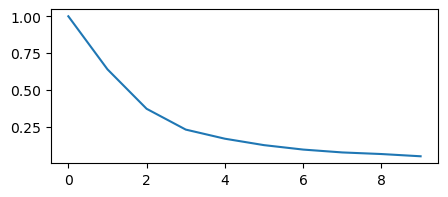

In [14]:
autocors = [df_train['y_imp'].autocorr(i) for i in range(10)]

plt.figure(figsize=[5,2])
plt.plot(autocors)
plt.show();

The figure above shows that perhaps it makes sense to compute the rolling means up for three days the most, as after that the autocorrelation gets too low.

In [15]:
# Compute new values: rolling means over 2 and 3 days
## Fill the NAs of N rows (N = size of rolling window) with the original values
df_train['y_imp_r2'] = df_train['y_imp'].rolling(2).mean()
nan_idx = df_train[df_train['y_imp_r2'].isnull()].index
df_train.loc[nan_idx.values, 'y_imp_r2'] = df_train.loc[nan_idx.values, 'y_imp_r2'].fillna(df_train.loc[nan_idx.values, 'y_imp'])

df_train['y_imp_r3'] = df_train['y_imp'].rolling(3).mean()
nan_idx = df_train[df_train['y_imp_r3'].isnull()].index
df_train.loc[nan_idx.values, 'y_imp_r3'] = df_train.loc[nan_idx.values, 'y_imp_r3'].fillna(df_train.loc[nan_idx.values, 'y_imp'])

df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,month_name,dayname,weekend,hour,season,h_type,is_holiday,y_imp,y_imp_r2,y_imp_r3
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,September,Wednesday,0,0,Autumn,not_hol,0,0.577001,0.577001,0.577001
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,September,Wednesday,0,1,Autumn,not_hol,0,0.594001,0.585501,0.594001
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,September,Wednesday,0,2,Autumn,not_hol,0,0.685001,0.639501,0.618668
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,September,Wednesday,0,3,Autumn,not_hol,0,1.016001,0.850501,0.765001
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,September,Wednesday,0,4,Autumn,not_hol,0,0.677001,0.846501,0.792668


Let's take a look at the different rolling means values:

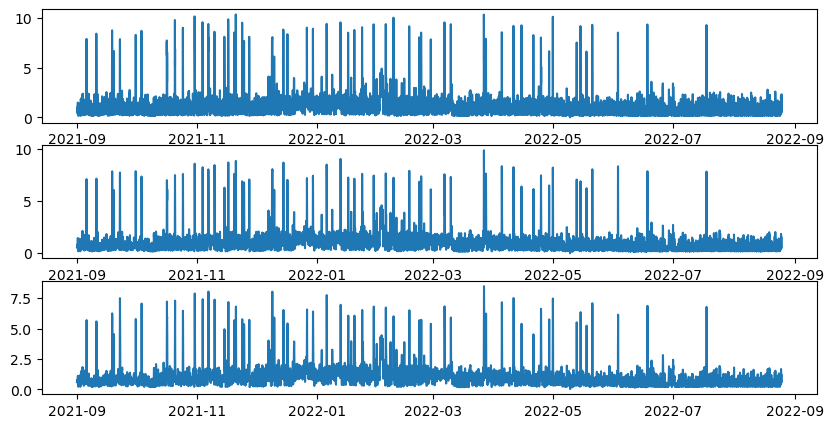

In [16]:
fig, (ax1, ax2, ax3,
     ) = plt.subplots(nrows = 3,
                      ncols = 1, figsize = [10, 5])
ax1.plot(df_train['time'], df_train['y_imp'])
ax2.plot(df_train['time'], df_train['y_imp_r2'])
ax3.plot(df_train['time'], df_train['y_imp_r3'])

plt.show();

There is still some a significant intra-day variation that results in spikes in the graphs. Let's try to further smooth these spikes by applying log-normalization. Let's then plot the results. Note: when predicting the values, make sure to exponentiate the predictions!

In [17]:
df_train['y_imp_log'] = np.log(df_train['y_imp'])
df_train['y_imp_r2_log'] =  np.log(df_train['y_imp_r2'])
df_train['y_imp_r3_log'] = np.log(df_train['y_imp_r3'])
df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,hour,season,h_type,is_holiday,y_imp,y_imp_r2,y_imp_r3,y_imp_log,y_imp_r2_log,y_imp_r3_log
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,0,Autumn,not_hol,0,0.577001,0.577001,0.577001,-0.549911,-0.549911,-0.549911
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,1,Autumn,not_hol,0,0.594001,0.585501,0.594001,-0.520874,-0.535287,-0.520874
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,2,Autumn,not_hol,0,0.685001,0.639501,0.618668,-0.378335,-0.447067,-0.480187
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,3,Autumn,not_hol,0,1.016001,0.850501,0.765001,0.015874,-0.161930,-0.267878
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,4,Autumn,not_hol,0,0.677001,0.846501,0.792668,-0.390083,-0.166644,-0.232351


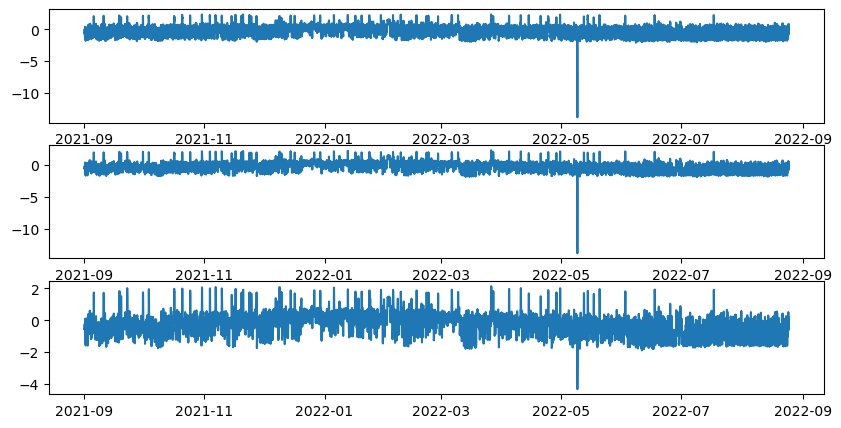

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, 
                      ncols = 1, figsize = [10, 5])
ax1.plot(df_train['time'], df_train['y_imp_log'])
ax2.plot(df_train['time'], df_train['y_imp_r2_log'])
ax3.plot(df_train['time'], df_train['y_imp_r3_log'])
plt.show();

# Modelling
In this section, we are running the models we used for predictions throughout the duration of this project. Of note, most of the modeling was performed in other notebooks - we refer the reader to look into them for more details. 

Because we adapted our approaches, data preprocessing, and modeling throughout the project time, the notebooks - although using largely similar approaches - have variations that result in differences between solutions below. For instance, there may have been variations in data cleaning, target variable use (i.e., using original,or imputed, or a moving average-based, or log-normalized values).


Below, we are presenting variations of the better solutions (without trying out all the possible, e.g., hyperparameter spaces we used).

The workflow is as follows:
1. We first prepare the train and testing data splits
2. We run the models that do not use time-series based modeling
3. We run the models that use time-series based modeling
4. We ensemble the best models

It should be noted that we found, in general, that the best models are obtained when we use the three-day moving average (`y_imp_r3`). During trying out different models and timeframes, we discovered that models where no more data than that from May 2022 were included performed well. To that end, the data from May 1 2022 were included. then, these data were randomly split to training and validation data.

## Preparing the test and training data
Here, we split the training data to train and val datasets. We also keep the test data separately.

In [19]:
# Extract all y-variables (including the augmented/transformed ones)
y_features = df_train.filter(regex='y_')

# Prepare the X-data
X = df_train.drop(columns = df_train.filter(regex='y_'))
X =  X.drop(columns = ['time'])

# Find the split time index
split_idx = X[(X['month_name'] == 'May') & (X['year'] == 2022) &  (X['hour'] == 0)].index[0]
X = X[split_idx:].reset_index(drop = True)
y_features = y_features[split_idx:].reset_index(drop = True)
y = y_features['y_imp_r3']

# Validation data
X_test = df_test.drop(columns = ['time'])

In [20]:
# Train-test split
## NB! There are several y-variables!

split_index = math.ceil(len(X) * 0.8) # 80%-20% split


#train_X, val_X, train_y, val_y = train_test_split(X, 
#                                                  y_features,
#                                                  random_state=0, 
#                                                  test_size = 0.20)
train_X = X[:split_index].reset_index(drop = True)
val_X = X[split_index:].reset_index(drop = True)
train_y = y[:split_index].reset_index(drop = True)
val_y = y[split_index:].reset_index(drop = True)

len(train_X), len(val_X)

(2228, 556)

### Feature pre-processing

In [21]:
# Collect a list of variable names based on type for subsequent use
num_vars = []
cat_vars = []
int_vars = []
for i in range(len(train_X.dtypes)):
    if train_X.dtypes.values[i] == 'float64':
        num_vars.append(train_X.dtypes.index[i])
    elif train_X.dtypes.values[i] == 'object':
        cat_vars.append(train_X.dtypes.index[i])
    elif train_X.dtypes.values[i] == 'int64':
        int_vars.append(train_X.dtypes.index[i])

In [22]:
# Scale the float variables
scaler = MinMaxScaler()

scaler.fit(train_X[num_vars])
train_X[num_vars] = scaler.transform(train_X[num_vars])
val_X[num_vars] = scaler.transform(val_X[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

# One-hot encoding for categorical vars
## Should be done for train (+ val) + test in one df because otherwise N of vars not the same
ohe_vars = pd.get_dummies(pd.concat([train_X[cat_vars], 
                                     val_X[cat_vars],
                                     X_test[cat_vars]
                                    ], 
                                    ignore_index=True))
ohe_vars = pd.get_dummies(pd.concat([train_X[cat_vars], val_X[cat_vars], X_test[cat_vars]], ignore_index=True))

In [23]:
# Drop the old categorical features
train_X = train_X.drop(columns = cat_vars)
val_X = val_X.drop(columns = cat_vars)
X_test = X_test.drop(columns = cat_vars)

In [24]:
# Add the OHE variables to train, test, and val data
len_xtrain = len(train_X)
len_xval = len(val_X)
len_xtest = len(X_test)

In [25]:
train_X = train_X.join(ohe_vars[:len_xtrain])
val_X = val_X.join(ohe_vars[len_xtrain:(len_xtrain + len_xval)].reset_index(drop = True))
X_test = X_test.join(ohe_vars[(len_xtrain + len_xval):].reset_index(drop = True))

In [26]:
# Initialize a df where the model performance will be collected
df_models = pd.DataFrame(columns = ['model', 'runtime', 'MAE'])
df_models.head()

,model,runtime,MAE


## Non-Time-Series Based Approaches
In this section, we will start off with the baseline models of 'usual suspects'-algorithms:
- Linear Regression
- Regularized Regression Models (Lasso, Ridge, Elastic Net)
- Decision Tree
- Random Forest

### Regressions
#### Linear Regression

In [27]:
lambda_ = 1 # provide a lambda value

start = time.time()
lr = LinearRegression()
lr.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict = lr.predict(val_X)
mae = mean_absolute_error(val_y, predict)
print(f'MAE: {mae}')

# Append to models df
df_models = df_models.append({'model': 'LR', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

MAE: 0.3195457631269932


#### Lasso Regression

In [28]:
start = time.time()
lr_lasso = Lasso(lambda_)
lr_lasso.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict = lr_lasso.predict(val_X)
mae = mean_absolute_error(val_y, predict)
print(f'MAE: {mae}')

# Append to models df
df_models = df_models.append({'model': 'Lasso', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

MAE: 0.277727790628636


#### Ridge Regression

In [29]:
start = time.time()
lr_ridge = Ridge(lambda_)
lr_ridge.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict = lr_ridge.predict(val_X)
mae = mean_absolute_error(val_y, predict)
print(f'MAE: {mae}')

# Append to models df
df_models = df_models.append({'model': 'Ridge', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

MAE: 0.28843628314592035


#### Elastic Net Regression

In [30]:
start = time.time()
lr_elastic = ElasticNet(alpha = lambda_)
lr_elastic.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict = lr_elastic.predict(val_X)
mae = mean_absolute_error(val_y, predict)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'ElasticNet', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

MAE: 0.2509215909038105


### Intermediate Summary
Below we are displaying the model MAEs with model runtimes:

In [31]:
df_models.sort_values('MAE', ascending = True)

,model,runtime,MAE
3,ElasticNet,0.003060,0.250922
1,Lasso,0.003339,0.277728
2,Ridge,0.003694,0.288436
0,LR,0.007561,0.319546


<font color = 'red'>The results are similar to the ones we initially obtained, i.e., Ridge regression had the best performance. The Ridge regression model's Kaggle score was **0.40911**. Based on this, we also experimented with hyperaprameter tuning but this did not yield a superior result.</font>

### Decision Tree
We also tried the decision tree regressor. After fitting a baseline, i.e., not tuned model, we used grid search for tuning the hyperparameters. This resulted in the below-outlined model:

In [32]:
start = time.time()
tuned_dt = DecisionTreeRegressor(max_depth=6,
                                 max_features='auto',
                                 max_leaf_nodes=20,
                                 min_samples_leaf=3,
                                 min_weight_fraction_leaf=0.1,
                                 splitter='random', 
                                random_state=0)
tuned_dt.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict = tuned_dt.predict(val_X)
mae = mean_absolute_error(val_y, predict)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'Tuned DT', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

MAE: 0.24506364901985156


However, Kaggle results showed that this Decision Tree had a score of **0.6426** - clearly unsatisfactory.


### Random Forest

In [33]:
start = time.time()
tuned_rf = RandomForestRegressor(n_estimators = 950, 
                                 bootstrap = False, 
                                 max_depth = None, 
                                 max_features = 'sqrt', 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2,
                                random_state= 0)

tuned_rf.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict = tuned_rf.predict(val_X)
mae = mean_absolute_error(val_y, predict)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'Tuned RF', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

MAE: 0.22175219172030822


The results in Kaggle were **0.48919**. These results were better than the ones from the Decision Tree but still not as good as the ones obtained from Ridge Regression.

### XGBoost

In [34]:
start = time.time()
xgb_best = xgb.XGBRegressor(colsample_bytree = 0.9, 
                                 learning_rate = 0.01, 
                                 max_depth = 10, 
                                 n_estimators = 400, seed=0)
xgb_best.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict = xgb_best.predict(val_X)
mae = mean_absolute_error(val_y, predict)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'XGBoost', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

MAE: 0.2204212480695568


### Intermediate summary

In [35]:
df_models.sort_values('MAE')

,model,runtime,MAE
6,XGBoost,1.761354,0.220421
5,Tuned RF,3.575980,0.221752
4,Tuned DT,0.003063,0.245064
3,ElasticNet,0.003060,0.250922
1,Lasso,0.003339,0.277728
2,Ridge,0.003694,0.288436
0,LR,0.007561,0.319546


## Time-Series Based Approaches

- `Prophet library`
- `Skforecast`

### Prophet

In [36]:
df_ts = df_train[['time', 'y_imp_r3']] # timeseries df
df_prophet = df_ts[split_idx:].reset_index(drop = True) # use the split index starting from May 1, 2022
df_prophet = df_prophet.rename(columns = {'time':'ds', 'y_imp_r3':'y'})
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)
df_prophet.head()

,ds,y
0,2022-05-01 00:00:00,0.610001
1,2022-05-01 01:00:00,0.290668
2,2022-05-01 02:00:00,0.494334
3,2022-05-01 03:00:00,0.783668
4,2022-05-01 04:00:00,0.974001


prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmp5422d873/duu8vd39.json
cmdstanpy  DEBUG input tempfile: /var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmp5422d873/lb71aj9r.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/drdr/opt/anaconda3/envs/ml_2022/lib/python3.7/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39111', 'data', 'file=/var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmp5422d873/duu8vd39.json', 'init=/var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmp5422d873/lb71aj9r.json', 'output', 'file=/var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmp5422d873/prophet_model3_ueyr5c/prophet_model-20221209181839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:39 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain 

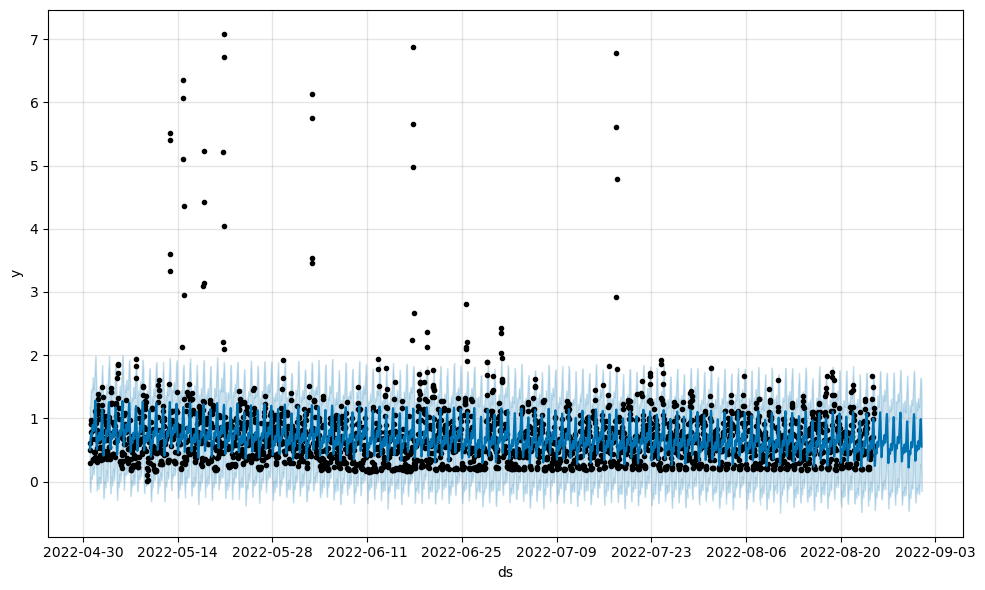

In [37]:
start = time.time()
m = Prophet(changepoint_prior_scale=0.01).fit(df_prophet)
future = m.make_future_dataframe(periods=168, freq='H')
fcst = m.predict(future)
runtime = time.time() - start

fig = m.plot(fcst)

In [38]:
# Print predictions table
fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-05-01 00:00:00,0.817244,-0.022921,1.189864,0.817244,0.817244,-0.216662,-0.216662,-0.216662,-0.220102,-0.220102,-0.220102,0.003440,0.003440,0.003440,0.0,0.0,0.0,0.600581
1,2022-05-01 01:00:00,0.817150,-0.153918,1.170267,0.817150,0.817150,-0.314463,-0.314463,-0.314463,-0.324667,-0.324667,-0.324667,0.010204,0.010204,0.010204,0.0,0.0,0.0,0.502687
2,2022-05-01 02:00:00,0.817057,-0.159033,1.237250,0.817057,0.817057,-0.282028,-0.282028,-0.282028,-0.298961,-0.298961,-0.298961,0.016933,0.016933,0.016933,0.0,0.0,0.0,0.535029
3,2022-05-01 03:00:00,0.816964,-0.053718,1.342263,0.816964,0.816964,-0.172588,-0.172588,-0.172588,-0.196123,-0.196123,-0.196123,0.023535,0.023535,0.023535,0.0,0.0,0.0,0.644376
4,2022-05-01 04:00:00,0.816871,0.084541,1.424110,0.816871,0.816871,-0.075617,-0.075617,-0.075617,-0.105536,-0.105536,-0.105536,0.029919,0.029919,0.029919,0.0,0.0,0.0,0.741254


Let's find the predicitions for the timeframe that was also used for other models.

In [39]:
preds_prophet = fcst.iloc[len(train_X):len(train_X)+len(val_X)].reset_index(drop = True)['yhat']

mae = mean_absolute_error(val_y, preds_prophet)

print(f'MAE: {mae}')
df_models = df_models.append({'model': 'Prophet', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Extract the predictions for test data (Kaggle)
# predictions = fcst.iloc[-168:][['ds', 'yhat']].reset_index(drop = True)
# predictions.head()

MAE: 0.21690303171667144


## Skforecast

In [40]:
----MISSING

NameError: name 'MISSING' is not defined

## Final Performance Results

In [41]:
df_models = df_models.sort_values('MAE').reset_index(drop = True)
df_models

,model,runtime,MAE
0,Prophet,0.764744,0.216903
1,XGBoost,1.761354,0.220421
2,Tuned RF,3.575980,0.221752
3,Tuned DT,0.003063,0.245064
4,ElasticNet,0.003060,0.250922
5,Lasso,0.003339,0.277728
6,Ridge,0.003694,0.288436
7,LR,0.007561,0.319546


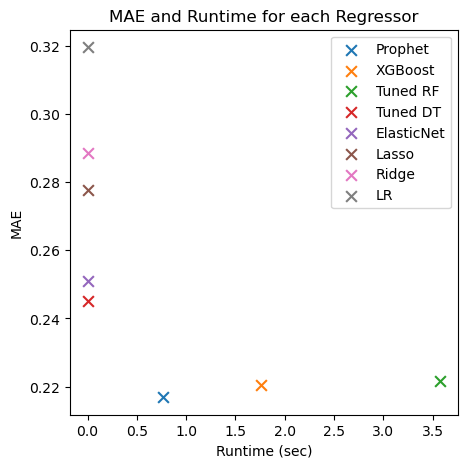

In [42]:
plt.figure(figsize = [5, 5])

for i in range(len(df_models)):

    plt.scatter(df_models['runtime'][i], 
            df_models['MAE'][i], 
            label = df_models['model'][i],
               marker = 'x',
               s = 60)
    plt.legend()
plt.xlabel('Runtime (sec)')
plt.ylabel('MAE')
plt.title('MAE and Runtime for each Regressor')
plt.show();